## 빅데이터 기반 AI 응용 솔루션 개발자 전문과정

#### 교과목명: 딥러닝 응용
- 평가일: 22.11.25
- 성명: 
- 점수: 

Q1. mnist datasets를 불러와서 PyTorch 프레임워크으로 다음을 수행하세요.
- 생성자 및 판별자 클래스 정의 및 학습데이터 불러오기
- 모델 학습 및 샘플링
 - 학습을 위한 생성자와 판매자 모델 초기화
 - 적절한 하이퍼 파라미터 설정(lr = 0.0002, betas=(0.5, 0.999))
 - 모델을 학습하면서 주기적으로 샘플링하여 결과 확인(n_epochs = 200, sample_interval = 2000)
- 생성된 이미지 예시 출력 

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output       

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
len(dataloader)

469

In [ ]:
dataiter = iter(dataloader)
images,labels = dataiter.next()
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# [유의] 14분 소요
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.542174] [G loss: 2.010308] [Elapsed time: 4.26s]
[Epoch 1/200] [D loss: 0.424071] [G loss: 1.283600] [Elapsed time: 8.33s]
[Epoch 2/200] [D loss: 0.385135] [G loss: 1.189226] [Elapsed time: 12.36s]
[Epoch 3/200] [D loss: 0.329851] [G loss: 1.455148] [Elapsed time: 16.56s]
[Epoch 4/200] [D loss: 0.929670] [G loss: 4.693035] [Elapsed time: 20.71s]
[Epoch 5/200] [D loss: 0.212239] [G loss: 2.208292] [Elapsed time: 24.81s]
[Epoch 6/200] [D loss: 0.293610] [G loss: 1.238725] [Elapsed time: 28.94s]
[Epoch 7/200] [D loss: 0.192902] [G loss: 1.565695] [Elapsed time: 33.22s]
[Epoch 8/200] [D loss: 0.253371] [G loss: 1.166367] [Elapsed time: 37.57s]
[Epoch 9/200] [D loss: 0.181564] [G loss: 3.096349] [Elapsed time: 41.64s]
[Epoch 10/200] [D loss: 0.700375] [G loss: 0.332555] [Elapsed time: 45.83s]
[Epoch 11/200] [D loss: 0.188818] [G loss: 1.783041] [Elapsed time: 49.88s]
[Epoch 12/200] [D loss: 0.153117] [G loss: 1.838707] [Elapsed time: 54.33s]
[Epoch 13/200] [D loss: 

In [ ]:
from IPython.display import Image

Image('92000.png')

Q2. 아래사항을 참조하여 로드된 ECG 데이터를 활용하여 이상치 감지 모델을 만든 후 성능 평가를 수행하세요.

[ECG5000 데이터세트]에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도]가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Download the dataset
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
dataframe.shape

(4998, 141)

In [ ]:
dataframe.iloc[:,-1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
# 데이터 정규화
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_data.shape

TensorShape([3998, 140])

In [ ]:
# 이 데이터세트에서 1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다. 정상 리듬과 비정상 리듬을 분리
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
pd.Series(train_labels).value_counts()

True     2359
False    1639
dtype: int64

In [ ]:
normal_train_data.shape

TensorShape([2359, 140])

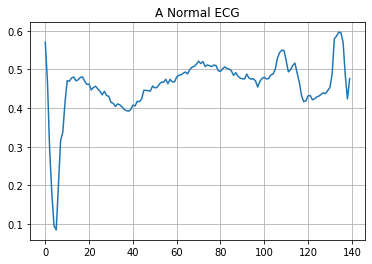

In [ ]:
# 정상적인 ECG를 플롯
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

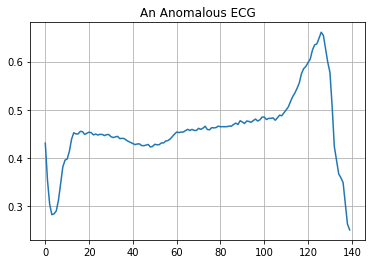

In [ ]:
# 비정상적인 ECG를 플롯
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
# 모델 빌드

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
# autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 3s 43ms/step - loss: 0.0577 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0559 - val_loss: 0.0521
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0535 - val_loss: 0.0507
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0506 - val_loss: 0.0488
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0475 - val_loss: 0.0470
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.0452
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.0435
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0379 - val_loss: 0.0422
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0351 - val_loss: 0.0410
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0326 - val_loss: 0.0401
Epoch 11/20
5/5 [=====================

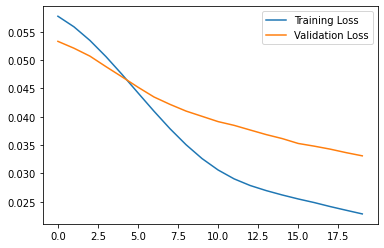

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다. 먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯

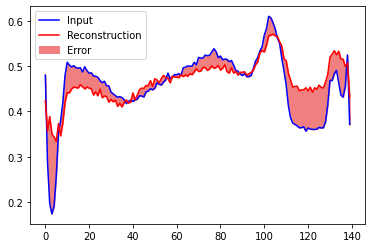

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

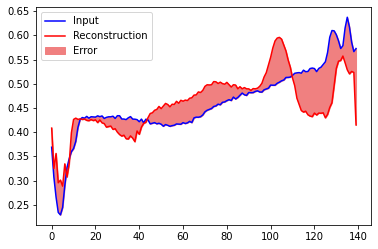

In [ ]:
# 이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

정상과 비정상의 가시적 비교로 부터 2개의 mae다 확연히 다르다는 점을 알 수 있다. 정상 학습용 데이터에 대해서 통상 평균값을 기준으로 표준편차 1시그마까지를 임계치로 잡을 경우 0.032임을 알 수 있다. 이에 비해 비정상 테스트 그래프는 대부분의 분포가 0.035 이상에 몰려 있음을 알 수 있다. 즉 autoencoding된 결과들과의 오차 절대값 비교관점에서 두 분포는 이질적이다. 즉 Anomaly가 포착되었가고 볼 수 있다.


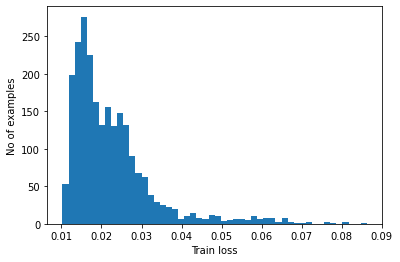

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# 평균보다 표준 편차가 높은 임계값을 선택
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03289008


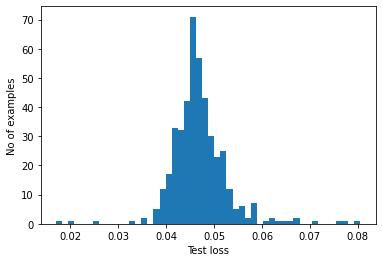

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.941
Precision = 0.9940828402366864
Recall = 0.9


Q3. YOLOv5를 활용하고 포트홀 데이터로 파인튜닝하여 "포트홀 탐지모델"을 개발하고 테스트 데이터 샘플에 대하여 포트홀 탐지가 되는지 확인하세요.

YOLOv5 : https://github.com/ultralytics/yolov5.git<br>
포트홀 데이터 : https://public.roboflow.com/object-detection/pothole

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 14450, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 14450 (delta 7), reused 14 (delta 5), pack-reused 14430
Receiving objects: 100% (14450/14450), 13.38 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (9985/9985), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 43.1 MB/s 


In [ ]:
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

/content/yolov5/pothole


In [ ]:
#  curl은 커맨드 아린용 데이터 전송 도구. -L 옵션을 사용하여 HTTP 위치 헤더를 따르기(리다이렉션을 따르도록 curl 을 사용할 수 있음)
!curl -L "https://public.roboflow.com/ds/bYJNNdPId2?key=WsonnjVSrC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1937      0 --:--:-- --:--:-- --:--:--  1937
100 46.0M  100 46.0M    0     0  15.5M      0  0:00:02  0:00:02 --:--:-- 27.2M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [ ]:
from glob import glob

train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list= glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/valid/images/*.jpg')
print(len(train_img_list), len(test_img_list),len(valid_img_list))

465 67 133


In [ ]:
import yaml

with open('/content/yolov5/pothole/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list)+'\n')

with open('/content/yolov5/pothole/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list)+'\n')

with open('/content/yolov5/pothole/valid.txt', 'w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
%cat /content/yolov5/pothole/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

In [ ]:
%%writetemplate /content/yolov5/pothole/data.yaml
train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [ ]:
%cat /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']


In [ ]:
# 모델 구성
import yaml
with open('/content/yolov5/pothole/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fa

In [ ]:
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pothole_results --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-215-g575055c Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!ls /content/yolov5/runs/train/pothole_results/

confusion_matrix.png				   results.png
events.out.tfevents.1667003182.06e2ec6ae84b.506.0  train_batch0.jpg
F1_curve.png					   train_batch1.jpg
hyp.yaml					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
opt.yaml					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


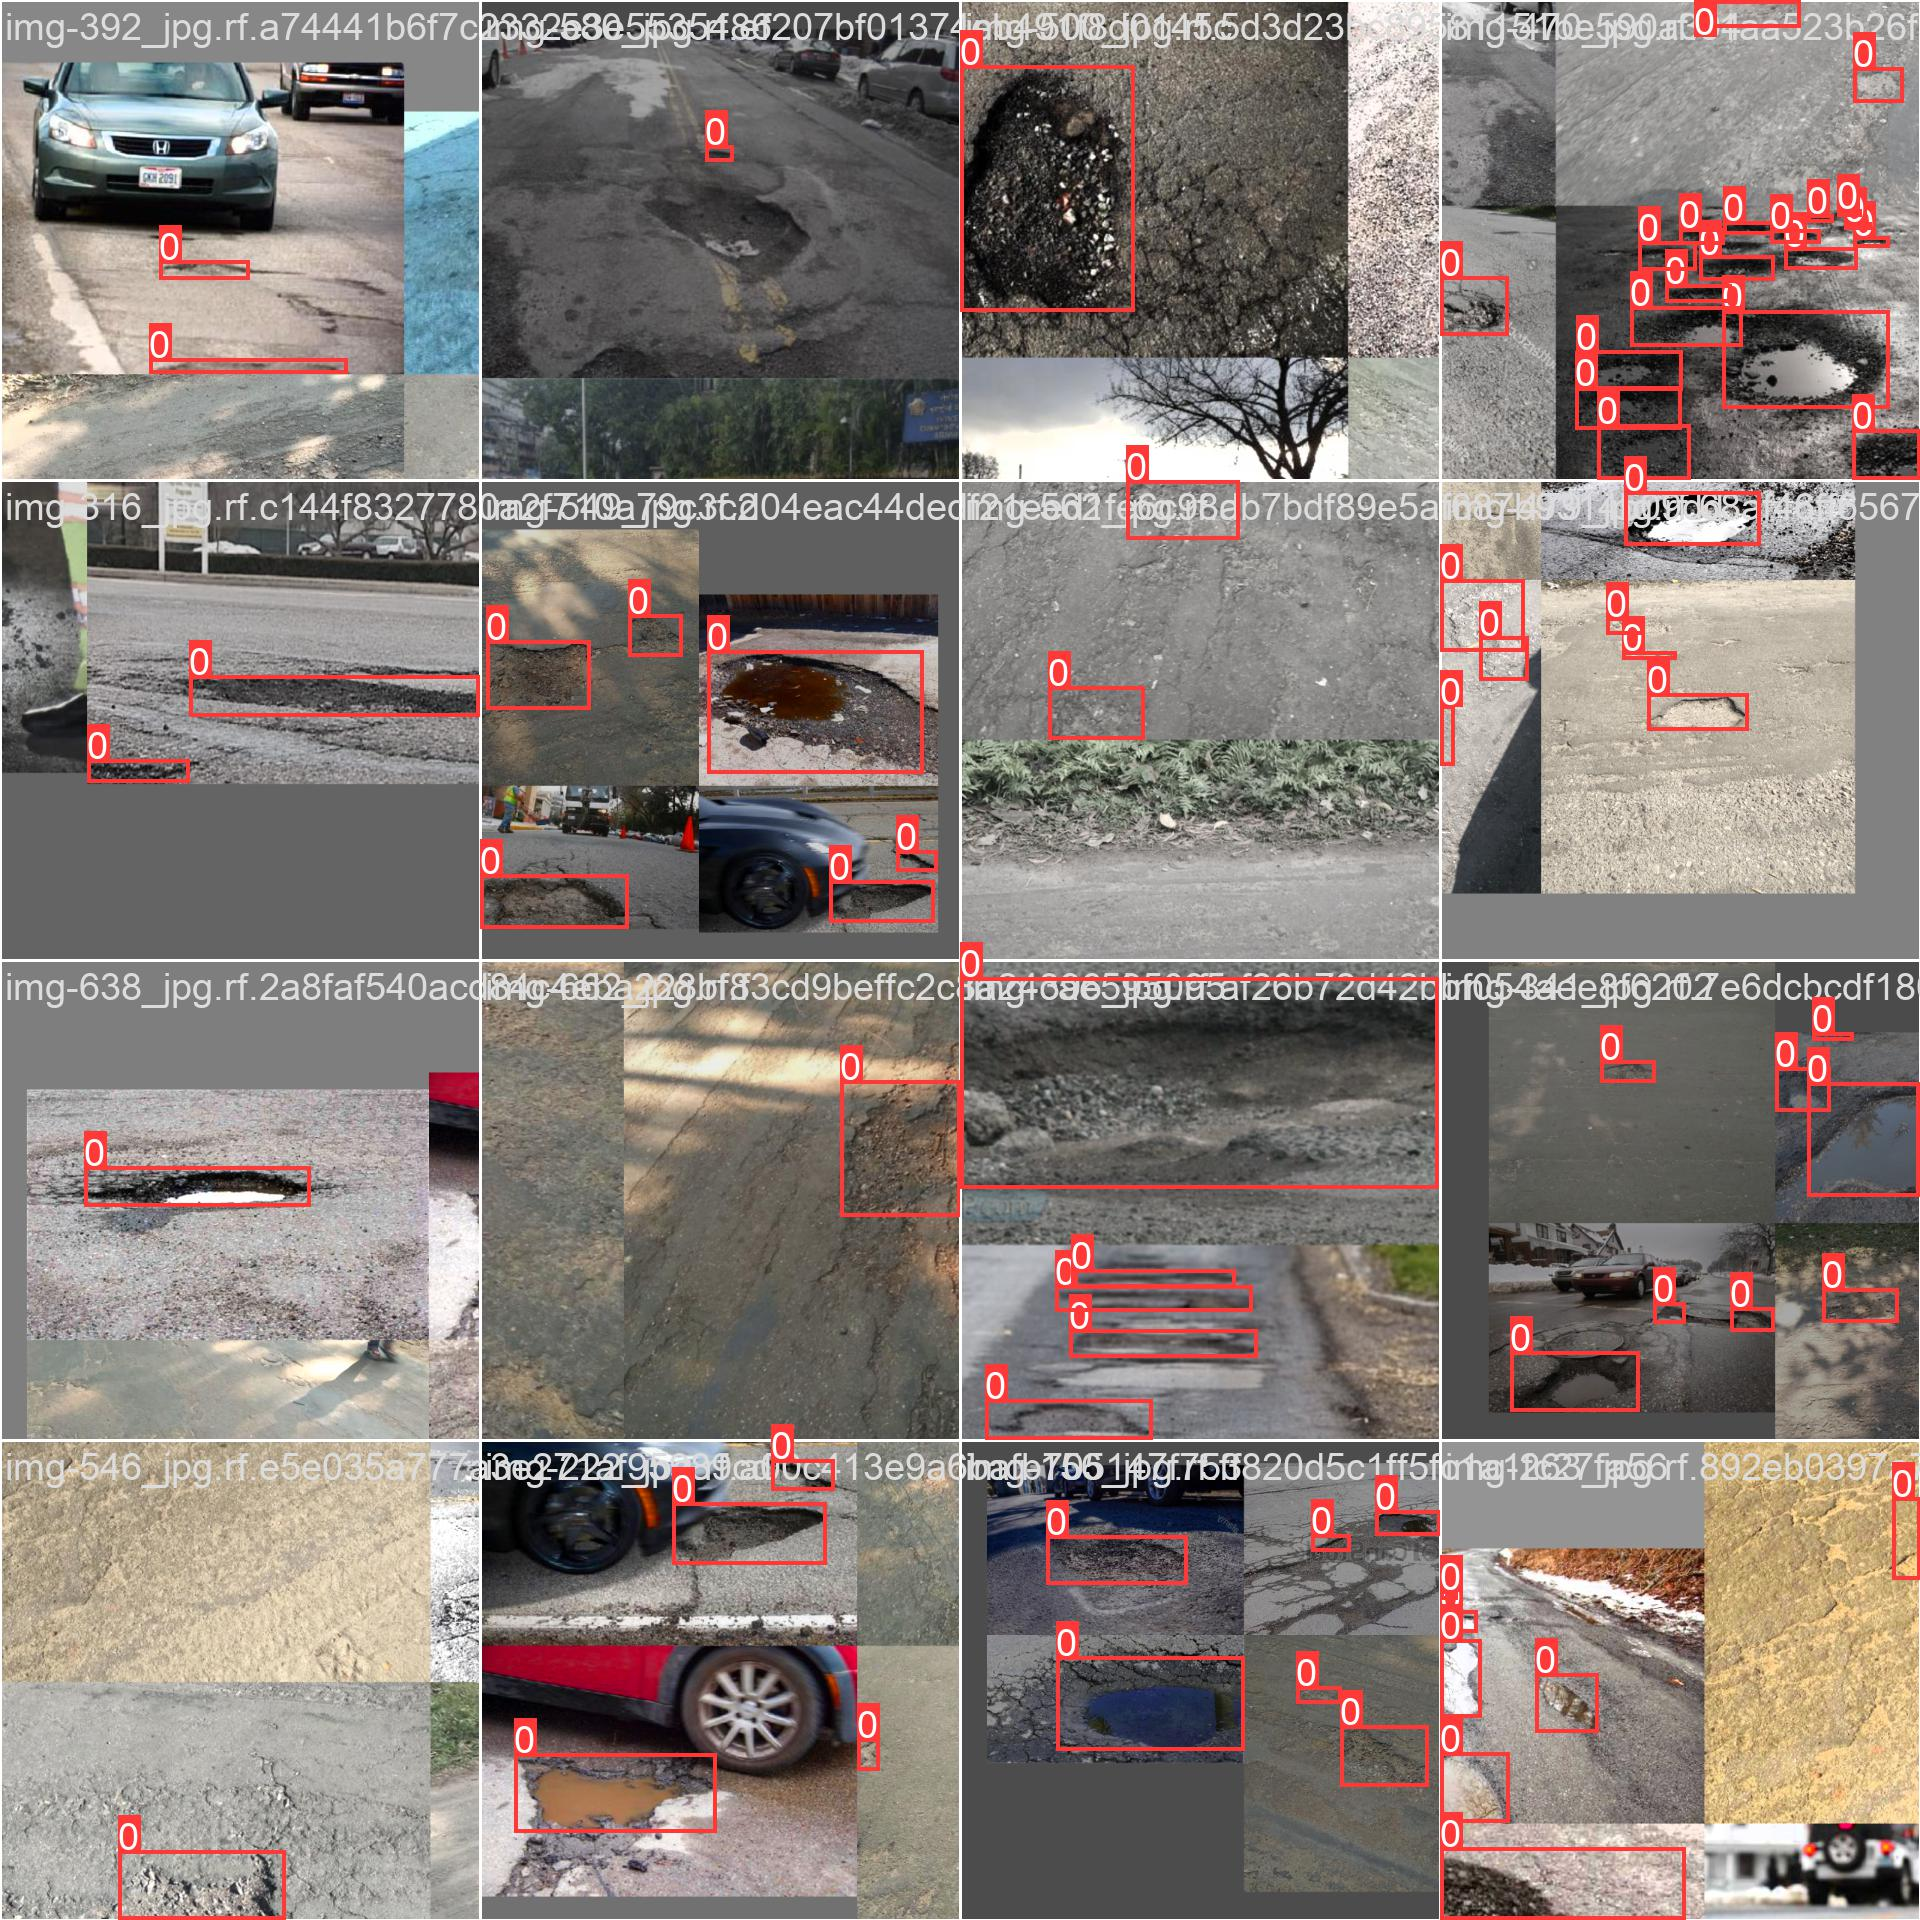

In [ ]:
Image(filename='/content/yolov5/runs/train/pothole_results/train_batch0.jpg',width=1000)

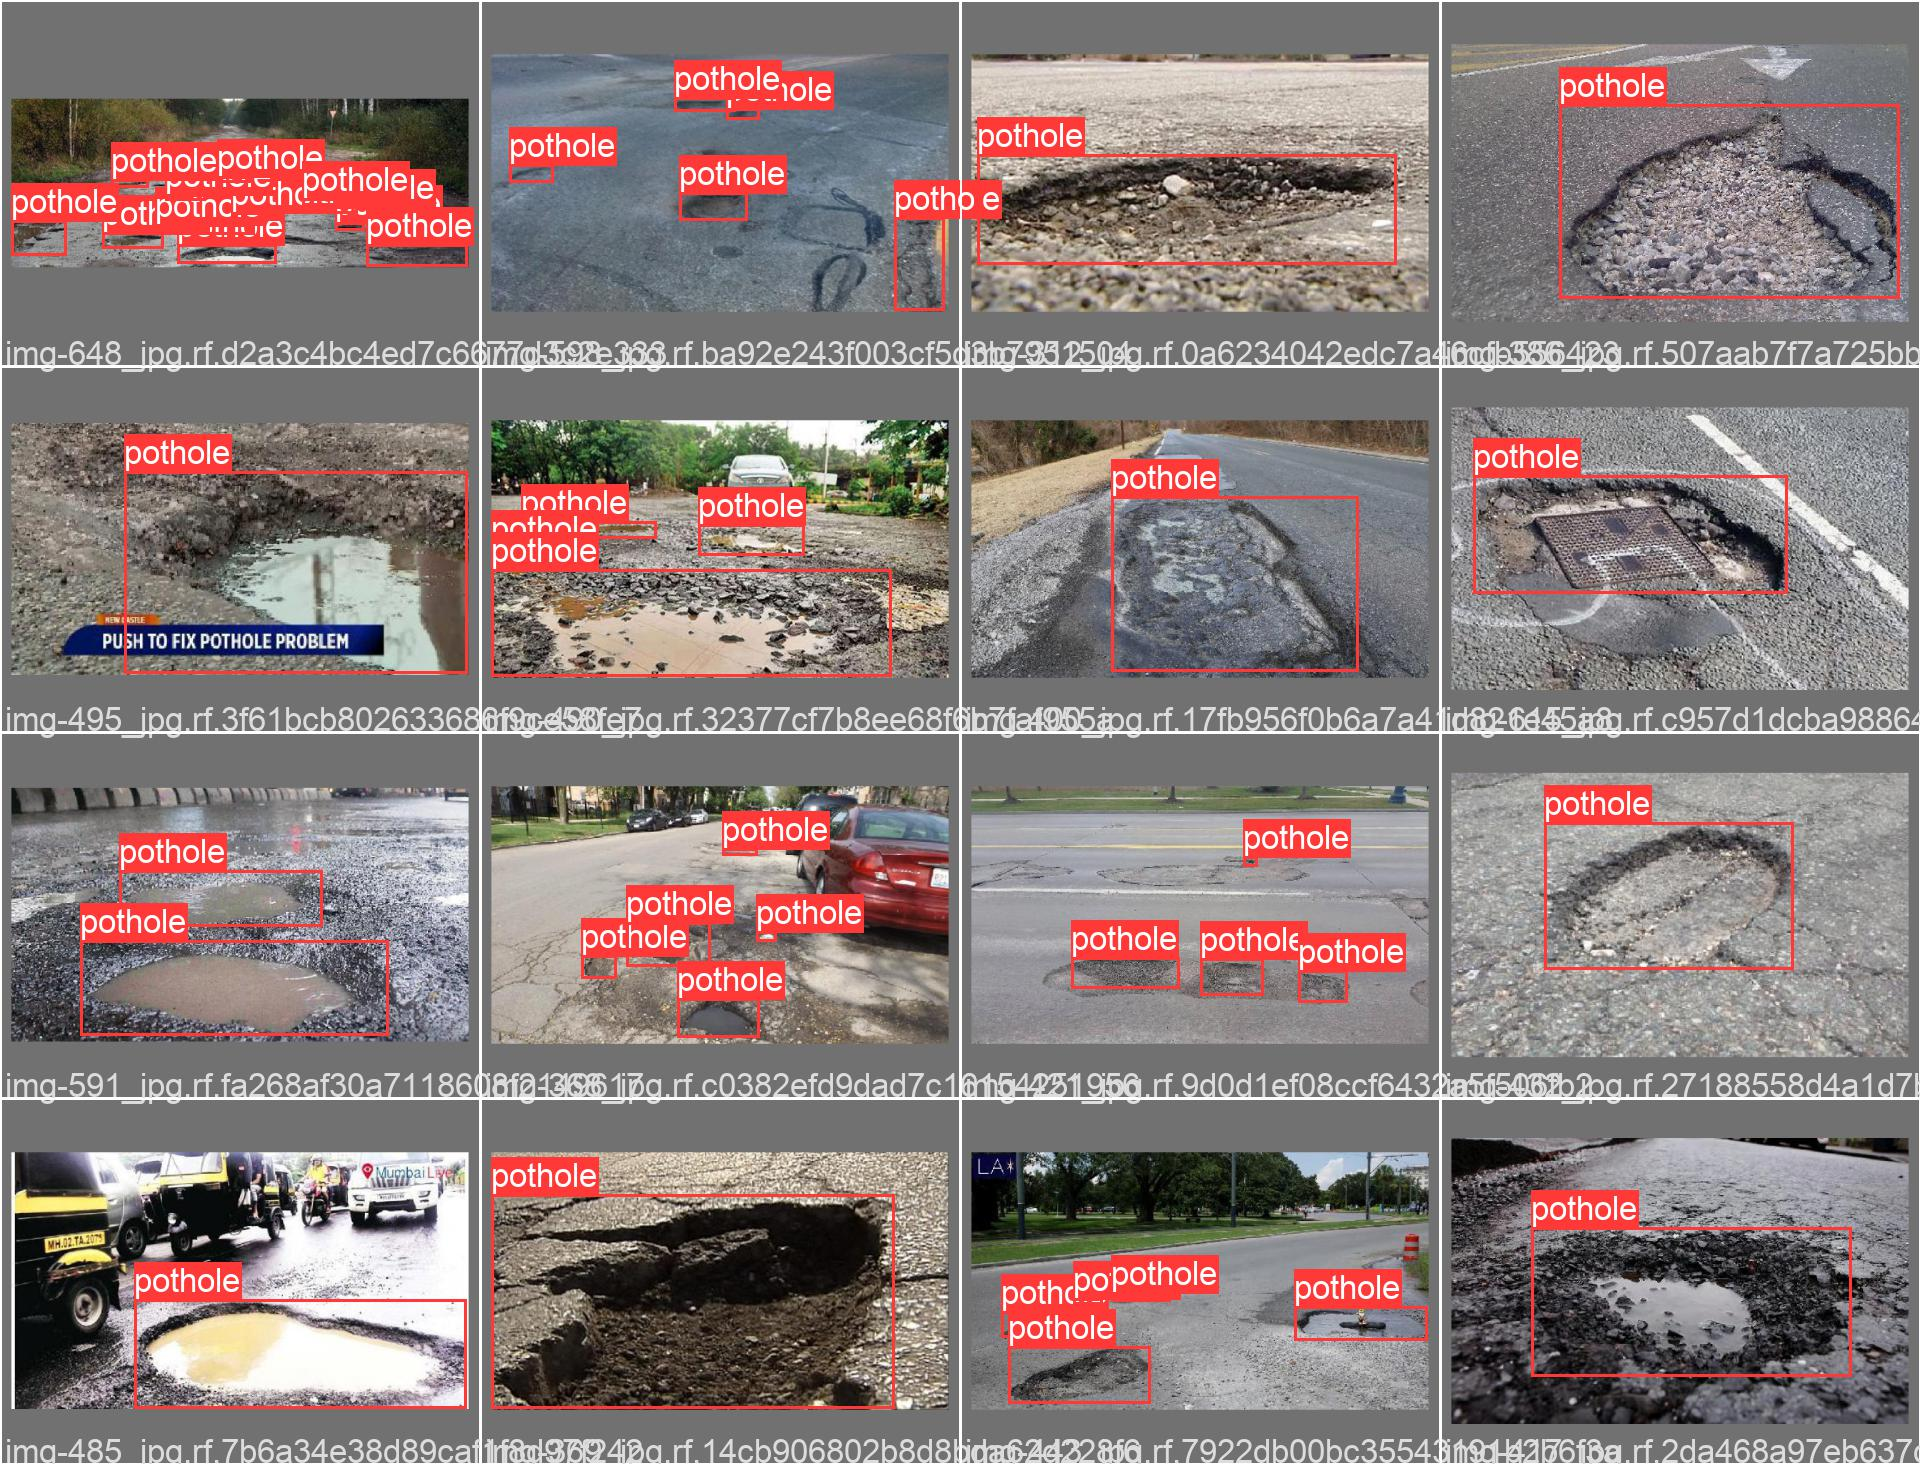

In [ ]:
Image(filename='/content/yolov5/runs/train/pothole_results/val_batch0_labels.jpg',width=1000)

In [ ]:
# 검증
!python val.py --weights runs/train/pothole_results/weights/best.pt --data ./pothole/data.yaml --img 640 --task test

val: data=./pothole/data.yaml, weights=['runs/train/pothole_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-215-g575055c Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '/content/yolov5/pothole/test/labels' images and labels...67 found, 0 missing, 0 empty, 0 corrupt: 100% 67/67 [00:00<00:00, 3538.96it/s]
test: New cache created: /content/yolov5/pothole/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:02<00:00,  1.38it/s]
                   all         67        154      0.785      0.689      0.757      0.419
Speed: 

In [ ]:
!python detect.py --weights runs/train/pothole_results/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['runs/train/pothole_results/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-215-g575055c Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, 12.7ms
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, 12.7ms
image 3/67 /content/yolov5/pothole/test/images/img-146_jpg.rf.61be25b305

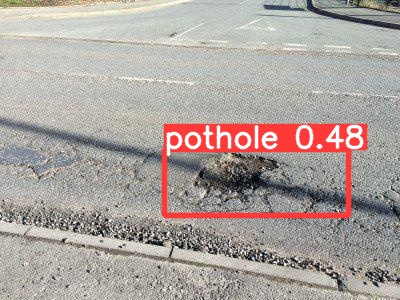

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

In [ ]:
# 모델 내보내기
%mkdir /content/drive/MyDrive/colab_lecture/강의/pothole
%cp /content/yolov5/runs/train/pothole_results/weights/best.pt /content/drive/MyDrive/colab_lecture/강의/pothole

Q4~5. 주어진 네이버 댓글 데이터 ratings_train.txt, ratings_test.txt 를 활용하여 아래 요구사항에 따라 감성분석 모델 생성 및 평가를 수행하세요.
- pre-trained model로 kobert 사용
- pre-trained model로 bert multilingual 사용

In [ ]:
%cd /content

/content


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 33.4 MB/s 
     |████████████████████████████████| 7.6 MB 60.4 MB/s 
     |████████████████████████████████| 182 kB 94.3 MB/s 


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 31.3 MB/s 


In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 29.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=aedd5dc6a5c4bb3796267e0e51684b5d4c2c56b2b52a1116b947bec0791d564d
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re
import sentencepiece as spm

In [ ]:
!pwd


/content


In [ ]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
os.listdir('nsmc')

['raw',
 '.git',
 'synopses.json',
 'ratings.txt',
 'ratings_test.txt',
 'ratings_train.txt',
 'code',
 'README.md']

In [ ]:
train = pd.read_table('nsmc/'+'ratings_train.txt')
test = pd.read_table('nsmc/'+'ratings_test.txt')
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# tokenization_kobert.py 업로드
from google.colab import files
files.upload()

Saving tokenization_kobert.py to tokenization_kobert.py


{'tokenization_kobert.py': b'# coding=utf-8\n# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park\n#\n# Licensed under the Apache License, Version 2.0 (the "License");\n# you may not use this file except in compliance with the License.\n# You may obtain a copy of the License at\n#\n#     http://www.apache.org/licenses/LICENSE-2.0\n#\n# Unless required by applicable law or agreed to in writing, software\n# distributed under the License is distributed on an "AS IS" BASIS,\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n# See the License for the specific language governing permissions and\n# limitations under the License.\n""" Tokenization classes for KoBert model."""\n\n\nimport logging\nimport os\nimport unicodedata\nfrom shutil import copyfile\n\nfrom transformers import PreTrainedTokenizer\n\n\nlogger = logging.getLogger(__name__)\n\nVOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3

In [ ]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

loading file tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/tokenizer_78b3253a26.model
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/tokenizer_config.json


Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Be

In [ ]:
def convert_data(data_df):
  global tokenizer
  SEQ_LEN = 64

  tokens, masks, segments, targets = [],[],[],[]

  for i in tqdm(range(len(data_df))):
    token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length',max_length=SEQ_LEN)
    num_zeros = token.count(0)
    mask = [1] * (SEQ_LEN-num_zeros) + [0] * num_zeros
    segment = [0] * SEQ_LEN

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    targets.append(data_df[LABEL_COLUMN][i])

  tokens = np.array(tokens)
  masks = np.array(masks)
  segments = np.array(segments)
  targets = np.array(targets)

  return [tokens, masks, segments], targets

In [ ]:
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x,data_y = convert_data(data_df)
  return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:31<00:00, 4723.84it/s]


In [ ]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:10<00:00, 4722.27it/s]


In [ ]:
# 버트를 활용한 감성분석 모델 생성

model = TFBertModel.from_pretrained('monologg/kobert', from_pt=True)
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
bert_output = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/config.json
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}



Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/pytorch_model.bin
Loading PyTorch weights from /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/pytorch_model.bin
PyTorch checkpoint contains 92,186,880 parameters
Loaded 92,186,880 parameters in the TF 2.0 model.
All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_output = bert_output[1]
bert_output.shape

TensorShape([None, 768])

In [ ]:
# optimizer

!pip install tensorflow_addons
import tensorflow_addons as tfa
# opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps=2344*2,warmup_proportion=0.1, min_lr=1e-5,epsilon=1e-08, clipnorm=1.0)
opt = tfa.optimizers.RectifiedAdam(lr=1.0e-5,weight_decay=0.0025, warmup_proportion=0.1)
# epsilon : A small constant for numerical stability
# clipnorm :	float or None. If set, clips gradients to a maximum norm.
# warmup_proportion :	A floating point value. The proportion of increasing steps.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.1 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_output)
sentiment_first = tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs,mask_inputs,segment_inputs],sentiment_first)
sentiment_model.compile(optimizer = opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

In [ ]:

# 25분 소요
sentiment_model.fit(train_x,train_y,epochs=2,shuffle=True,batch_size=64,validation_data=(test_x,test_y))

Epoch 1/2
2344/2344 [==============================] - 2185s 920ms/step - loss: 0.4292 - accuracy: 0.7849 - val_loss: 0.3006 - val_accuracy: 0.8713
Epoch 2/2
2344/2344 [==============================] - 2158s 921ms/step - loss: 0.2834 - accuracy: 0.8804 - val_loss: 0.2726 - val_accuracy: 0.8873


In [ ]:
sentiment_model.evaluate(test_x,test_y)

1563/1563 [==============================] - 218s 140ms/step - loss: 0.2726 - accuracy: 0.8873


[0.27258211374282837, 0.8873400092124939]

google bert-base-multilingual-cased 적용

In [ ]:
# 버트 인풋 만들기
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer_config.json


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

In [ ]:
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x,data_y = convert_data(data_df)
  return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:47<00:00, 3154.49it/s]


In [ ]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:15<00:00, 3210.43it/s]


In [ ]:
# 버트를 활용한 감성분석 모델 생성

model = TFBertModel.from_pretrained('bert-base-multilingual-cased', from_pt=True)
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
bert_output = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/pytorch_model.bin
Loading PyTorch weights from /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/pytorch_model.bin
PyTorch checkpoint contains 270,378,749 parameters
Loaded 177,853,440 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertFor

In [ ]:
bert_output = bert_output[1]
bert_output.shape

TensorShape([None, 768])

In [ ]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_output)
sentiment_first = tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs,mask_inputs,segment_inputs],sentiment_first)
sentiment_model.compile(optimizer = opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
sentiment_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',      

In [ ]:
sentiment_model.fit(train_x,train_y,epochs=2,shuffle=True,batch_size=64,validation_data=(test_x,test_y))

Epoch 1/2
2344/2344 [==============================] - 2249s 949ms/step - loss: 0.3897 - accuracy: 0.8196 - val_loss: 0.3406 - val_accuracy: 0.8508
Epoch 2/2
2344/2344 [==============================] - 2222s 948ms/step - loss: 0.3065 - accuracy: 0.8653 - val_loss: 0.3276 - val_accuracy: 0.8611


In [ ]:
sentiment_model.evaluate(test_x,test_y)

1563/1563 [==============================] - 219s 140ms/step - loss: 0.3276 - accuracy: 0.8611


[0.32761338353157043, 0.8610600233078003]